CPU Time for training: 0.004013776779174805 seconds 

CPU Time for prediction: 0.001994609832763672 seconds 

The best max depth value for this algorithm is  50 

The CCP value:  0.0001
The Mean Squared Error is  0.015090239499652706 

The R Squared Error is 0.9674688575820247 

Predicted ZHVI values for 2025:
    1/31/2025  2/28/2025  3/31/2025  4/30/2025  5/31/2025  6/30/2025  \
0    2.590692   2.590692   2.590692   2.590692   2.590692   2.590692   
1   -0.440874  -0.440874  -0.440874  -0.440874  -0.440874  -0.440874   
2   -0.139047  -0.139047  -0.139047  -0.139047  -0.139047  -0.139047   
3    0.835211   0.835211   0.835211   0.835211   0.835211   0.835211   
4   -0.618685  -0.618685  -0.618685  -0.618685  -0.618685  -0.618685   
5   -0.618685  -0.618685  -0.618685  -0.618685  -0.618685  -0.618685   
6   -0.821535  -0.821535  -0.821535  -0.821535  -0.821535  -0.821535   
7   -0.513115  -0.513115  -0.513115  -0.513115  -0.513115  -0.513115   
8   -0.513115  -0.513115  -0.513115  -0.

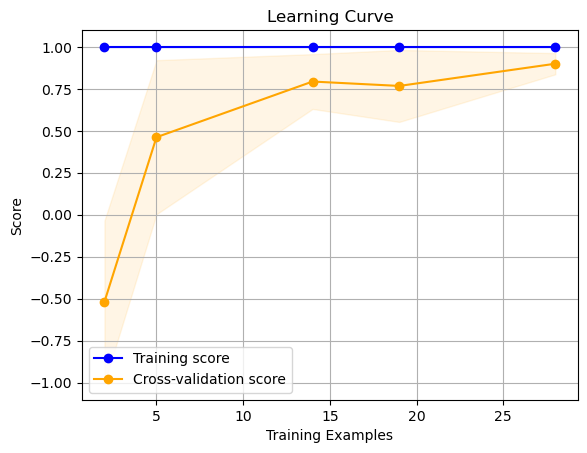

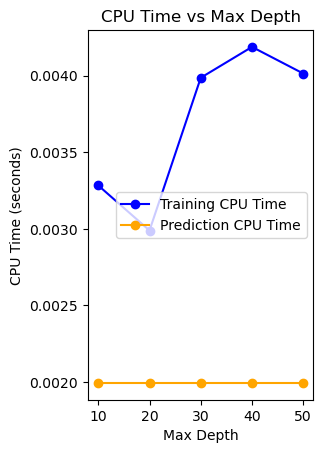

In [37]:
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import StandardScaler 
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score



realEstateData = pd.read_csv('Zillow Real Estate Data.csv')
# Drop the 'StateName' column since the data is not needed for the linear regression algorithm
realEstateData.drop(columns=['StateName'], inplace=True)

#this creates a numeric_columns variable that receives 
numeric_columns = realEstateData.select_dtypes(include='number').columns

# this excludes the size rank and region column so that the values aren't converted when standardized
# Standardizing the data is important so that when linear regression is applied, the values will be in the same range
# for accurate results

exclude_columns = ['SizeRank', 'RegionID']
zhvi_columns = [col for col in numeric_columns if col not in exclude_columns]

# Fill missing values for ZHVI columns with the mean
realEstateData[zhvi_columns] = realEstateData[zhvi_columns].fillna(realEstateData[zhvi_columns].mean())

scaler = StandardScaler()
realEstateData[zhvi_columns] = scaler.fit_transform(realEstateData[zhvi_columns])

future_date = '6/30/2020'

y = realEstateData[future_date]
x = realEstateData.drop(columns=['1/31/2000', 'SizeRank', 'RegionID', 'RegionName', 'RegionType',future_date])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

data_model = DecisionTreeRegressor(random_state =42)
data_model.fit(x_train, y_train)

param_grid = {'ccp_alpha': [0.0001, 0.001, 0.005,0.01], 'max_depth' : [10,20,30,50]}
grid_search = GridSearchCV(data_model, param_grid, cv = 7, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

ccp_value = grid_search.best_params_['ccp_alpha']
#max_depth_value = grid_search.best_params_['max_depth']
#print(ccp_value)
#print(max_depth_value)


#To plot the CPU times against the max depth value, create an empty list for training and prediction
# Initializes max_depth_values list with values
cpu_times_train = []
cpu_times_predict = []
mse_values = []
max_depth_values = [10, 20, 30, 40, 50 ] 
max_depth_used = 0

#This will loop over each value in the max depth values list 
for depth in max_depth_values:
    data_model_pruned = DecisionTreeRegressor(ccp_alpha = ccp_value, max_depth = depth, random_state =42 ) #, min_samples_leaf = 5, min_samples_split = 10
    #data_model_pruned.fit(x_train, y_train)

    if depth > max_depth_used:
        max_depth_used = depth
    #y_prediction = data_model_pruned.predict(x_test)
    #print(y_prediction)
    #mse = mean_squared_error(y_test, y_prediction)
    

    start_time_train = time.time()
    data_model_pruned.fit(x_train, y_train)
    end_time_train = time.time()

    cpu_time_train = end_time_train - start_time_train
    

    # Measure wall-clock time for predicting
    start_time_predict = time.time()
    y_prediction = data_model_pruned.predict(x_test)
    end_time_predict = time.time()
    
    cpu_times_train.append(cpu_time_train)
    cpu_times_predict.append(cpu_time_predict)
    mse_values.append(mse)

    #cpu_time_predict = end_time_predict - start_time_predict

mse = mean_squared_error(y_test, y_prediction)
r_squared = r2_score(y_test, y_prediction)
    
print(f'CPU Time for training: {cpu_time_train} seconds \n')
print(f'CPU Time for prediction: {cpu_time_predict} seconds \n')
print('The best max depth value for this algorithm is ', max_depth_used, '\n')
print('The CCP value: ', ccp_value)
print('The Mean Squared Error is ',mse,'\n')
print('The R Squared Error is', r_squared, '\n')

#y_train_prediction = data_model.predict(x_train)


future_dates = ['1/31/2025', '2/28/2025', '3/31/2025', '4/30/2025', '5/31/2025', '6/30/2025', 
                '7/31/2025', '8/31/2025', '9/30/2025', '10/31/2025', '11/30/2025', '12/31/2025']

new_dataframe = realEstateData.copy()



for date in future_dates:
    # Make predictions using only the original features (zhvi_columns) from the data, excluding the future date columns
    new_dataframe[date] = data_model_pruned.predict(x)
    

#y_train_prediction = data_model.predict(x_train)
# Calculate MSE for the training set
#mse_train = mean_squared_error(y_train, y_train_prediction)
#print("Mean Squared Error for training set:", mse_train)

# Print the predicted ZHVI values for 2025
print("Predicted ZHVI values for 2025:")
print(new_dataframe[future_dates])
#print(realEstateData.head())

#To get a visual of the decision tree
#plt.figure(figsize=(20, 10))
#plot_tree(data_model, filled = True, feature_names = x.columns, fontsize = 6)
#plt.savefig('decision_tree.png', bbox_inches='tight')
#plt.show()
#plt.close()


#looping over each date to plot
#for date in future_dates:
    #plt.plot(new_dataframe.index, new_dataframe[date], marker='o', label=f'Predicted {date}')

# Add labels and title
#plt.xlabel('Index (e.g., regions)')
#plt.ylabel('Predicted Home Values (ZHVI)')
#plt.title('Predicted ZHVI Values for Future Dates')

# Rotate X-axis labels for better readability
#plt.xticks(rotation=45)

# Add a legend to differentiate between the dates
#plt.legend()

# Show grid for better visualization
#plt.grid(True)

# Show the plot
#plt.show()
train_sizes, train_scores, test_scores = learning_curve(data_model, x_train, y_train, cv=5, n_jobs=-1, train_sizes=[0.1, 0.2, 0.5, 0.7, 1.0])

# Calculate the mean and standard deviation of training scores
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)

# Calculate the mean and standard deviation of test scores
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

# Plot the learning curve
plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label='Cross-validation score')

# Plot the std deviation as a shadow
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='orange')

plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.savefig('Decision Tree with Pruning Learning Curve.png', bbox_inches='tight')

plt.show()



plt.subplot(1, 2, 1)
plt.plot(max_depth_values, cpu_times_train, marker='o', label='Training CPU Time', color='blue')
plt.plot(max_depth_values, cpu_times_predict, marker='o', label='Prediction CPU Time', color='orange')
plt.xlabel('Max Depth')
plt.ylabel('CPU Time (seconds)')
plt.title('CPU Time vs Max Depth')
plt.legend()
plt.savefig('Decision Tree with Pruning.png', bbox_inches='tight')